In [18]:
import pandas as pd 

import json
import pandas as pd 
from typing import List, Dict
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

In [177]:
def hierarchical_exact_match(test_data: List[Dict]) -> float:
    """
    Calculates hierarchical exact match accuracy (HEM).
    Only counts a prediction as correct if both levels are correct.
    
    Reference: Kosmopoulos et al. (2015) https://arxiv.org/pdf/1306.6802
    """
    correct = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
        and item['true_subtopic'] == item['pred_subtopic']
    )
    return correct / len(test_data)

def hierarchical_precision_recall(test_data: List[Dict]) -> Dict:
    """
    Calculates hierarchical precision and recall (hP and hR).
    Takes into account the hierarchical structure when computing metrics.
    
    Reference: Kiritchenko et al. (2005)
    https://www.researchgate.net/profile/Svetlana-Kiritchenko/publication/44054157_Hierarchical_Text_Categorization_as_a_Tool_of_Associating_Genes_with_Gene_Ontology_Codes/links/09e4150b3962e7f77e000000/Hierarchical-Text-Categorization-as-a-Tool-of-Associating-Genes-with-Gene-Ontology-Codes.pdf
    https://www.mdpi.com/2079-9292/13/7/1199#sec3dot1dot4-electronics-13-01199 (good)
    """
    total_precision = 0
    total_recall = 0
    
    for item in test_data:
        # Create sets of predicted and true paths
        true_path = {item['true_global_topic'], f"{item['true_global_topic']}/{item['true_subtopic']}"}
        pred_path = {item['pred_global_topic'], f"{item['pred_global_topic']}/{item['pred_subtopic']}"}
        # print()
        # Calculate intersection of predicted and true paths
        common = len(true_path.intersection(pred_path))
        
        # Calculate precision and recall for this instance
        precision = common / len(pred_path) if pred_path else 0
        recall = common / len(true_path) if true_path else 0
        
        total_precision += precision
        total_recall += recall
    
    avg_precision = total_precision / len(test_data)
    avg_recall = total_recall / len(test_data)
    
    # Calculate hierarchical F1
    h_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return {
        'hierarchical_precision': avg_precision,
        'hierarchical_recall': avg_recall,
        'hierarchical_f1': h_f1
    }
def level_based_accuracy(test_data: List[Dict]) -> Dict:
    """
    Calculates accuracy at each level and the weighted combination.
    
    Reference: Sun & Lim (2001)
    """
    # Level 1 (Global Topic) accuracy https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=1975&context=sis_research
    l1_correct = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
    )
    l1_accuracy = l1_correct / len(test_data)
    
    # Level 2 (Subtopic) accuracy, only considering cases where level 1 was correct
    l2_eligible = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
    )
    l2_correct = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
        and item['true_subtopic'] == item['pred_subtopic']
    )
    l2_accuracy = l2_correct / l2_eligible if l2_eligible > 0 else 0
    
    # Weighted combination (you can adjust weights based on importance)
    w1, w2 = 0.6, 0.4  # Example weights
    weighted_accuracy = (w1 * l1_accuracy) + (w2 * l2_accuracy)
    
    return {
        'level1_accuracy': l1_accuracy,
        'level2_accuracy': l2_accuracy,
        'weighted_accuracy': weighted_accuracy
    }

def evaluate_hierarchical_classification(test_data: List[Dict]) -> Dict:
    """
    Comprehensive evaluation of hierarchical classification performance.
    """
    metrics = {}
    
    # Basic hierarchical exact match
    metrics['exact_match'] = hierarchical_exact_match(test_data)
    
    # Hierarchical precision and recall
    h_metrics = hierarchical_precision_recall(test_data)
    metrics.update(h_metrics)
    
    # Level-based accuracy
    l_metrics = level_based_accuracy(test_data)
    metrics.update(l_metrics)
    
    return metrics

In [178]:
# load model prediction 
llama3_70b = "../output/llama3.3-70b.json"
llama3_8b = "../output/llama-3.1-8b.json"
gpt_4o = "../output/gpt-4o.json"
gpt_5 = "../output/gpt-5.json"

gemma3_27b = "../output/gemma-3-27b.json"
gemma2_9b = "../output/gemma-2-9b.json"
qwen_7b = "../output/qwen-2.5-7b.json"
mixtral_7b = "../output/mixtral-8-7b.json"
aya_8b = "../output/aya-expanse-8b.json"
llama3_Gaja_8b = "../output/LLama3-Gaja-Hindi-8B-v0.1.json"
AryaBhatta = "../output/AryaBhatta.json"
clude_3_sonnet="../output/claude-3.5-sonnet.json"
airavata = "../output/Airavata.json"
Krutrim2_12B_instruct = "../output/Krutrim.json"
sarvam_m = "../output/sarvam-m.json"


# reported_models = [GPT-5, GPT-4o, Claude-3.5-Sonnet, Llama-3.3-70B-Instruct, Gemma-3-27B-IT, Llama-3-Gaja-Hindi-8B, Sarvam-M]

# choose the model from reported_models and take the model_data_path accordingly 
model_name = "Llama-3-Gaja-Hindi-8B"
model_data_path = llama3_Gaja_8b

with open(model_data_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

pred = []
for d in data: 
    pred.append({
        "Index": d['Index'],
        "pred_topic": d['topic'],
        "pred_subtopic": d['subtopic']
    })

model_pred = pd.DataFrame(pred)
data[0], model_pred['pred_topic'][4], len(model_pred)

({'Index': 0,
  'query': 'kya is it normal to have irregular periods',
  'topic': 'Menstrual Health',
  'subtopic': 'Menstrual Cycle Information',
  'confidence': 0.9,
  'reason': 'The query is about understanding the normalcy of irregular periods, which falls under menstrual cycle information.',
  'raw_output': '```json\n{\n  "Topic": "Menstrual Health",\n  "Subtopic": "Menstrual Cycle Information",\n  "Confidence": 0.9,\n  "Reason": "The query is about understanding the normalcy of irregular periods, which falls under menstrual cycle information."\n}',
  'model': 'Cognitive-Lab/LLama3-Gaja-Hindi-8B-v0.1'},
 'PCOS or PCOD',
 4161)

In [179]:
model_pred.isnull().sum()

Index            0
pred_topic       0
pred_subtopic    0
dtype: int64

In [180]:
model_pred['pred_topic'].value_counts() 

pred_topic
Menstrual Health                     1377
Contraception and Family Planning    1291
Pregnancy and PNC                     618
Sexual and Vaginal Health             483
PCOS or PCOD                          121
Other                                  83
Diet and Nutrition                     73
HIV                                    42
Mental Health and Wellness             37
Exercise and Fitness                   12
Marriage & Relationships               12
Breastfeeding                           3
Vaginal and Uterine Health              2
Vaginal and Sexual Health               2
Vaginal Health and Discharge            2
Period Pain Management                  1
Sterilization                           1
Relationship and Marriage               1
Name: count, dtype: int64

In [181]:
def topic_post_processing(topic):
    if topic in ['PCOS or PCOD', 'PCOD or PCOD', 'PCOD', 'PCOS', 'PCOS and PCOD']: 
        return 'PCOS/PCOD'
    elif topic in ['Genetics or Pregnancy and PNC is not present but closest is Pregnancy and PNC']: 
        return 'Pregnancy and PNC'
    elif topic in ['Contraceception and Family Planning', 'Family Planning']: 
        return 'Contraception and Family Planning'
    elif topic in ['Vaginal and Sexual Health', 'Sexual Health', 'Vaginal and Uterine Health', 'Vaginal Health and Discharge']: 
        return 'Sexual and Vaginal Health'
    else:
        return topic

model_pred['pred_topic'] = model_pred['pred_topic'].apply(lambda x: topic_post_processing(x))

In [182]:
model_pred['pred_topic'].values

array(['Menstrual Health', 'Menstrual Health', 'Menstrual Health', ...,
       'Menstrual Health', 'PCOS/PCOD',
       'Contraception and Family Planning'], shape=(4161,), dtype=object)

In [183]:
model_pred.head(2)

,Index,pred_topic,pred_subtopic
0,0,Menstrual Health,Menstrual Cycle Information
1,1,Menstrual Health,Menstrual Flow


In [184]:
data = pd.read_excel("../data/hinglish/final_jmir_data/cleaned_data_for_jmir.xlsx")
data.head(2)

,Message ID,Index,User Content,Topic,Sub Topic
0,19676,0,kya is it normal to have irregular periods,Menstrual Health,Menstrual Cycle Information
1,19844,1,Mere private part ke aas paas jalne jaisa mehsoos ho raha hai periods ke dauraan.,Menstrual Health,Period Pain Management


In [185]:
data.isnull().sum()

Message ID      504
Index             0
User Content      0
Topic             0
Sub Topic         0
dtype: int64

In [186]:
data['Topic'].value_counts()

Topic
Contraception and Family Planning    1417
Menstrual Health                     1104
Other                                 596
Pregnancy and PNC                     547
Sexual and Vaginal Health             322
PCOS/PCOD                             101
HIV                                    52
Mental Health and Wellness             22
Name: count, dtype: int64

In [187]:
merged_df = pd.merge(data, model_pred, on='Index', how='inner')
merged_df.head(2)

,Message ID,Index,User Content,Topic,Sub Topic,pred_topic,pred_subtopic
0,19676,0,kya is it normal to have irregular periods,Menstrual Health,Menstrual Cycle Information,Menstrual Health,Menstrual Cycle Information
1,19844,1,Mere private part ke aas paas jalne jaisa mehsoos ho raha hai periods ke dauraan.,Menstrual Health,Period Pain Management,Menstrual Health,Menstrual Flow


In [188]:
merged_df['pred_topic'].value_counts()

pred_topic
Menstrual Health                     1377
Contraception and Family Planning    1291
Pregnancy and PNC                     618
Sexual and Vaginal Health             489
PCOS/PCOD                             121
Other                                  83
Diet and Nutrition                     73
HIV                                    42
Mental Health and Wellness             37
Exercise and Fitness                   12
Marriage & Relationships               12
Breastfeeding                           3
Sterilization                           1
Period Pain Management                  1
Relationship and Marriage               1
Name: count, dtype: int64

In [189]:
merged_df[merged_df['pred_topic'] == "Exercise and Fitness"]

,Message ID,Index,User Content,Topic,Sub Topic,pred_topic,pred_subtopic
1252,18546,1283,Kya ulti ke samay kis tarha ka physical activity kiya ja sakta hai?,Pregnancy and PNC,Antepartum,Exercise and Fitness,General Exercise and Fitness Queries
1924,NaN,1977,Kya warm-up karne se pehle stretching karna bhi zaroori hai?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Queries
1926,NaN,1979,Kya halki jogging karne se pehle kuch aur bhi karna chahiye?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Queries
1953,NaN,2006,Kya main kisi bhi physical activity ko kar sakti hoon jaise yoga ya walking?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Queries
2087,NaN,2145,Kya main in exercises ko rozana kar sakti hoon ya hafte mein kitni baar karna chahiye?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Queries
2091,NaN,2149,Kya aap mujhe kuch simple vayayam bata sakte hain jo main ghar par kar sakti hoon?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Guidance
2096,NaN,2154,Yoga aur vayayam ke liye koi specific exercise recommend kar sakte hain?,Other,Exercise and Fitness,Exercise and Fitness,Specific Exercise Recommendations
2172,NaN,2231,Halka vayayam ya walk karne se kaise madad milti hai?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Queries
2337,20456,2399,Kya aap mujhe kuch aasan vayayam bata sakti hain jo main ghar par kar sakti hoon?,Other,Exercise and Fitness,Exercise and Fitness,General Health Queries
2348,21673,2410,Strength training ke liye mujhe gym jaana zaroori hai ya ghar par bhi kar sakti hoon?,Other,Exercise and Fitness,Exercise and Fitness,General Exercise Queries


In [190]:
model_test_data = []
for index, row in merged_df.iterrows(): 
    model_test_data.append({
        'true_global_topic': row['Topic'],
        'true_subtopic': row['Sub Topic'], 
        'pred_global_topic': row['pred_topic'], 
        'pred_subtopic': row['pred_subtopic']
    })

In [191]:
metrics = evaluate_hierarchical_classification(model_test_data)
print(model_data_path)
metrics

../output/LLama3-Gaja-Hindi-8B-v0.1.json


{'exact_match': 0.4518144676760394,
 'hierarchical_precision': 0.5962509012256669,
 'hierarchical_recall': 0.5962509012256669,
 'hierarchical_f1': 0.5962509012256669,
 'level1_accuracy': 0.7406873347752944,
 'level2_accuracy': 0.6099935107073329,
 'weighted_accuracy': 0.6884098051481098}

In [192]:
valid_topics = ['Contraception and Family Planning', 'Sexual and Vaginal Health', 'HIV', 'Pregnancy and PNC', 
                'PCOS/PCOD', 'Menstrual Health', 'Mental Health and Wellness', 'Other']
valid_topics

['Contraception and Family Planning',
 'Sexual and Vaginal Health',
 'HIV',
 'Pregnancy and PNC',
 'PCOS/PCOD',
 'Menstrual Health',
 'Mental Health and Wellness',
 'Other']

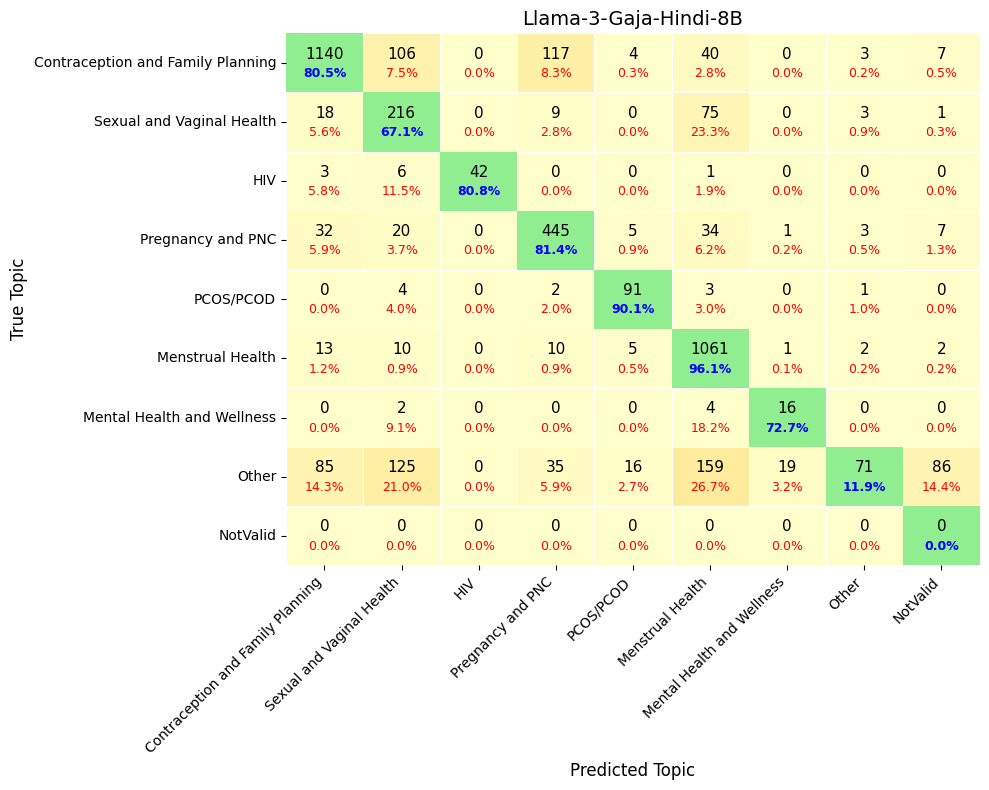

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.cm as mpl_cm  
from matplotlib.colors import Normalize


# --- Inputs ---
true_topics = [item['true_global_topic'] for item in model_test_data]

# Instead of forcing to "Other", mark as "NotValid"
pred_topics = [
    item['pred_global_topic'] if item['pred_global_topic'] in valid_topics else "NotValid"
    for item in model_test_data
]

# Extend the labels to include NotValid
all_labels = valid_topics + ["NotValid"]

# --- Confusion matrix + row % ---
cm = confusion_matrix(true_topics, pred_topics, labels=all_labels)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid div-by-zero
cm_pct = (cm / row_sums) * 100

# --- Heatmap background ---
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    cmap="YlOrRd",
    cbar=False,
    xticklabels=all_labels,
    yticklabels=all_labels,
    linewidths=0.5,
    linecolor="white"
)

# --- Green diagonal cells ---
for i in range(cm.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="lightgreen", ec="white", lw=0))


# --- Green diagonal cells scaled by value ---
# scale_by = "count"   # or "percent"
# diag_vals = np.diag(cm if scale_by == "count" else cm_pct)

# vmin, vmax = float(diag_vals.min()), float(diag_vals.max())
# if vmin == vmax:
#     vmax = vmin + 1e-9

# norm = Normalize(vmin=vmin, vmax=vmax)

# # Use only the lighter 70% of the Greens colormap
# greens_full = mpl_cm.get_cmap("Greens")
# greens = lambda x: greens_full(0.3 + 0.6 * x)  # shifts range to [0.3–1.0]

# for i in range(cm.shape[0]):
#     value = diag_vals[i]
#     ax.add_patch(
#         plt.Rectangle(
#             (i, i), 1, 1,
#             fill=True,
#             color=greens(norm(value)),  # lighter-to-medium green
#             ec="white", lw=0, zorder=3
#         )
#     )

# --- Annotations: count (black) + percentage (blue/red) ---
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_pct[i, j]
        # count
        ax.text(
            j + 0.5, i + 0.35, f"{count}",
            ha="center", va="center",
            color="black", fontsize=11
        )
        # percentage: blue for correct (diagonal), red otherwise
        color = "blue" if i == j else "red"
        ax.text(
             j + 0.5, i + 0.68, f"{percent:.1f}%", 
             ha="center", va="center",
             color=color, fontsize=9, 
             fontweight="semibold" if i == j else "normal"
         )


# import matplotlib.patches as mpatches
# legend_handles = [
#     mpatches.Patch(fc="forestgreen", label="Correct (diagonal)"),
#     mpatches.Patch(fc="#fdae61", label="Misclassification (low)"),
#     mpatches.Patch(fc="#d7301f", label="Misclassification (high)")
# ]
# ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)


# --- Labels & title ---
# plt.title("Topic-Level Confusion Matrix", fontsize=14)
plt.title(f"{model_name}", fontsize=14)
plt.xlabel("Predicted Topic", fontsize=12)
plt.ylabel("True Topic", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)


# Bold tick labels
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, fontweight="normal", rotation=45, ha="right")
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, fontweight="bold", rotation=0)

# ax.set_aspect('equal')          # square cells
plt.tight_layout()
plt.savefig(f"../figures/{model_name}_confusion_matrix_confusion_matrix_without_total.png", dpi=300, bbox_inches="tight", pad_inches=0.2)
plt.show()


In [194]:
model_name

'Llama-3-Gaja-Hindi-8B'

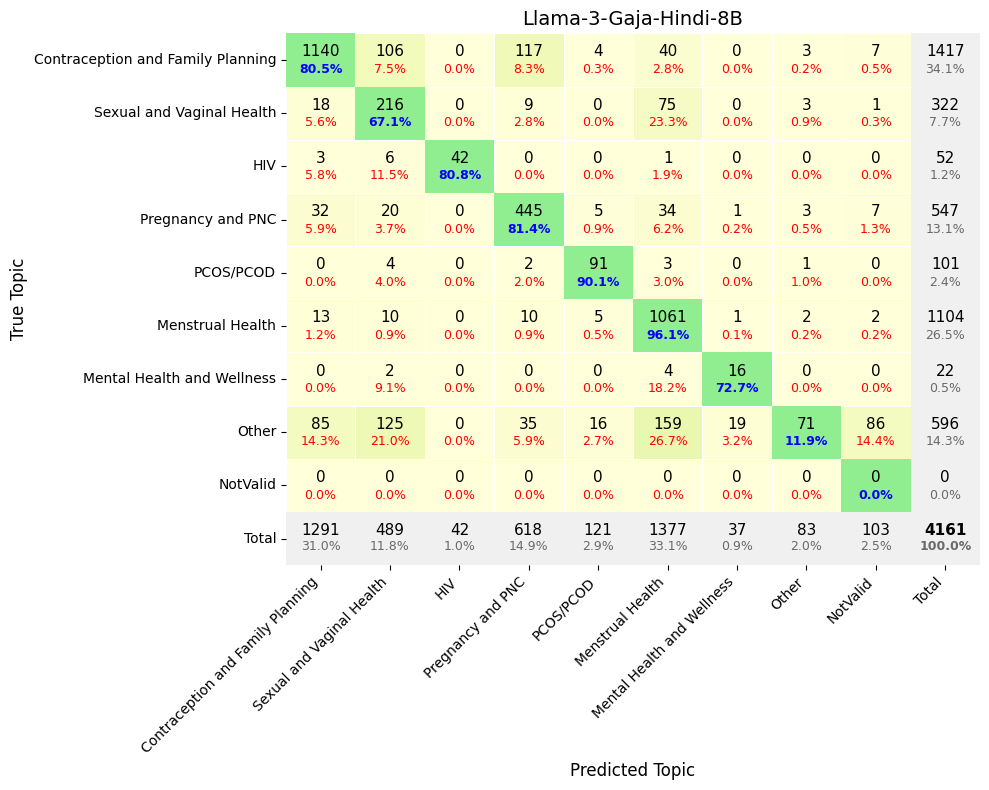

In [ ]:
# Final Confusion Matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Inputs ---
true_topics = [item['true_global_topic'] for item in model_test_data]

# Map OOV to NotValid
pred_topics = [
    item['pred_global_topic'] if item['pred_global_topic'] in valid_topics else "NotValid"
    for item in model_test_data
]

# Labels + NotValid
all_labels = valid_topics + ["NotValid"]
n = len(all_labels)

# --- Confusion matrix + row % ---
cm = confusion_matrix(true_topics, pred_topics, labels=all_labels)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid div-by-zero
cm_pct = (cm / row_sums) * 100

# --- Build extended matrix with totals (last row/col = totals) ---
col_sums = cm.sum(axis=0, keepdims=True)       # 1 x n
row_sums_flat = cm.sum(axis=1, keepdims=True)  # n x 1 (true supports)
grand_total = cm.sum()

cm_ext = np.zeros((n+1, n+1), dtype=int)
cm_ext[:n, :n] = cm
cm_ext[:n, n]  = row_sums_flat.flatten()     # last col = row totals
cm_ext[n, :n]  = col_sums.flatten()          # last row = col totals
cm_ext[n, n]   = grand_total                 # bottom-right

# For plotting, don't let totals dominate colors
vmax_main = cm.max() if cm.size else 1

# --- Heatmap background ---
# plt.figure(figsize=(12, 10))
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    cm_ext,
    annot=False,
    fmt="d",
    cmap="YlGnBu",
    cbar=False,
    xticklabels=all_labels + ["Total"],
    yticklabels=all_labels + ["Total"],
    linewidths=0.5,
    linecolor="white",
    vmax=vmax_main  # clip colors to main block max
)

# Shade totals row/col lightly so they read as margins
for j in range(n+1):
    ax.add_patch(plt.Rectangle((j, n), 1, 1, fill=True, color="#f0f0f0", ec="white", lw=0))
for i in range(n+1):
    ax.add_patch(plt.Rectangle((n, i), 1, 1, fill=True, color="#f0f0f0", ec="white", lw=0))

# Green diagonal for correct predictions (only main block)
for i in range(n):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="lightgreen", ec="white", lw=0))

# --- Annotations ---
# main block: count + row % (blue on diagonal, red off-diagonal)
for i in range(n):
    for j in range(n):
        count = cm[i, j]
        pct = cm_pct[i, j]
        ax.text(j + 0.5, i + 0.35, f"{count}", ha="center", va="center",
                color="black", fontsize=11)
        color = "blue" if i == j else "red"
        ax.text(j + 0.5, i + 0.68, f"{pct:.1f}%", ha="center", va="center",
                color=color, fontsize=9, fontweight="bold" if i == j else "normal")

# totals row (column supports): percent of grand total
for j in range(n):
    count = cm_ext[n, j]
    pct = (count / grand_total * 100) if grand_total else 0.0
    ax.text(j + 0.5, n + 0.5 - 0.15, f"{count}", ha="center", va="center",
            color="black", fontsize=11)
    ax.text(j + 0.5, n + 0.5 + 0.15, f"{pct:.1f}%", ha="center", va="center",
            color="dimgray", fontsize=9)

# totals column (row supports): percent of grand total
for i in range(n):
    count = cm_ext[i, n]
    pct = (count / grand_total * 100) if grand_total else 0.0
    ax.text(n + 0.5, i + 0.35, f"{count}", ha="center", va="center",
            color="black", fontsize=11)
    ax.text(n + 0.5, i + 0.68, f"{pct:.1f}%", ha="center", va="center",
            color="dimgray", fontsize=9)

# bottom-right grand total
ax.text(n + 0.5, n + 0.5 - 0.15, f"{grand_total}", ha="center", va="center",
        color="black", fontsize=11, fontweight="bold")
ax.text(n + 0.5, n + 0.5 + 0.15, "100.0%", ha="center", va="center",
        color="dimgray", fontsize=9, fontweight="bold")

# --- Labels & title ---
# plt.title("Topic-Level Confusion Matrix (with Totals)", fontsize=14)
plt.title(f"{model_name}", fontsize=14)

plt.xlabel("Predicted Topic", fontsize=12)
plt.ylabel("True Topic", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"../figures/{model_name}_confusion_matrix_with_total.png", dpi=300, bbox_inches="tight", pad_inches=0.2)
plt.show()


In [196]:
# All TOpic Acc and F1 score  
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Get unique topics
topics = merged_df['Topic'].unique()


# Calculate accuracy per topic
# topic_accuracy = {}

# for topic in topics:
#     # Filter data for the current topic
#     topic_data = merged_df[merged_df['Topic'] == topic]
    
#     # Calculate accuracy
#     accuracy = accuracy_score(merged_df['Topic'], merged_df['pred_topic'])
#     topic_accuracy[topic] = accuracy

# # Display accuracy per topic
# for topic, acc in topic_accuracy.items():
#     print(f"{topic}: {acc:.2f}")

# # Optionally, get detailed classification report
# print("\nClassification Report:\n", classification_report(merged_df['Topic'], merged_df['pred_topic']))



report_dict = classification_report(merged_df['Topic'], merged_df['pred_topic'], output_dict=True)

for class_label in topics:
    metrics = report_dict.get(class_label, None)
    if metrics:
        print(f"Class: {class_label}")
        for metric, value in metrics.items():
            print(f"  {metric.capitalize()}: {value:.2f}")
        print("-" * 30)


Class: Menstrual Health
  Precision: 0.77
  Recall: 0.96
  F1-score: 0.86
  Support: 1104.00
------------------------------
Class: PCOS/PCOD
  Precision: 0.75
  Recall: 0.90
  F1-score: 0.82
  Support: 101.00
------------------------------
Class: Contraception and Family Planning
  Precision: 0.88
  Recall: 0.80
  F1-score: 0.84
  Support: 1417.00
------------------------------
Class: Sexual and Vaginal Health
  Precision: 0.44
  Recall: 0.67
  F1-score: 0.53
  Support: 322.00
------------------------------
Class: Pregnancy and PNC
  Precision: 0.72
  Recall: 0.81
  F1-score: 0.76
  Support: 547.00
------------------------------
Class: Other
  Precision: 0.86
  Recall: 0.12
  F1-score: 0.21
  Support: 596.00
------------------------------
Class: Mental Health and Wellness
  Precision: 0.43
  Recall: 0.73
  F1-score: 0.54
  Support: 22.00
------------------------------
Class: HIV
  Precision: 1.00
  Recall: 0.81
  F1-score: 0.89
  Support: 52.00
------------------------------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [197]:
# Extract topic-level true and predicted labels
# Extract topic-level labels
print(model_data_path)
true_topics = [item['true_global_topic'] for item in model_test_data]
pred_topics = [
    item['pred_global_topic'] if item['pred_global_topic'] in valid_topics else None
    for item in model_test_data
]

# Keep only pairs where prediction is in valid topics
filtered_true = []
filtered_pred = []
for t, p in zip(true_topics, pred_topics):
    if p is not None:     # exclude NotValid
        filtered_true.append(t)
        filtered_pred.append(p)

from sklearn.metrics import accuracy_score, classification_report

topic_acc = accuracy_score(filtered_true, filtered_pred)
print(f"Topic-Level Accuracy (excluding NotValid): {topic_acc:.3f}")


topic_report = classification_report(
    filtered_true,
    filtered_pred,
    labels=valid_topics,         # only your valid classes
    target_names=valid_topics,
    digits=3
    # output_dict=True    
)

print("Topic-Level Classification Report (Excluding NotValid):\n")
print(topic_report)


../output/LLama3-Gaja-Hindi-8B-v0.1.json
Topic-Level Accuracy (excluding NotValid): 0.759
Topic-Level Classification Report (Excluding NotValid):

                                   precision    recall  f1-score   support

Contraception and Family Planning      0.883     0.809     0.844      1410
        Sexual and Vaginal Health      0.442     0.673     0.533       321
                              HIV      1.000     0.808     0.894        52
                Pregnancy and PNC      0.720     0.824     0.769       540
                        PCOS/PCOD      0.752     0.901     0.820       101
                 Menstrual Health      0.771     0.963     0.856      1102
       Mental Health and Wellness      0.432     0.727     0.542        22
                            Other      0.855     0.139     0.239       510

                         accuracy                          0.759      4058
                        macro avg      0.732     0.730     0.687      4058
                     weigh

In [198]:
# Get report as dictionary instead of string
print(model_data_path)
print("--"*20)
topic_report = classification_report(
    filtered_true,
    filtered_pred,
    labels=valid_topics,
    target_names=valid_topics,
    digits=2,
    output_dict=True
)

# Extract only F1-scores
f1_scores = {label: round(metrics["f1-score"], 2) for label, metrics in topic_report.items() if label in valid_topics}


topics = [
    "Contraception and Family Planning", "Menstrual Health", "Pregnancy and PNC", "Sexual and Vaginal Health",
    "PCOS/PCOD", "HIV", "Mental Health and Wellness", "Other"
]
for topic in topics: 
    print(f"{topic} = {f1_scores[topic]}")
    

../output/LLama3-Gaja-Hindi-8B-v0.1.json
----------------------------------------
Contraception and Family Planning = 0.84
Menstrual Health = 0.86
Pregnancy and PNC = 0.77
Sexual and Vaginal Health = 0.53
PCOS/PCOD = 0.82
HIV = 0.89
Mental Health and Wellness = 0.54
Other = 0.24


In [199]:
data = [
{
    # Open Weight  
    "mixtral_7b": {
     'exact_match': 0.452535448209565,
     'hierarchical_precision': 0.5928863254025475,
     'hierarchical_recall': 0.5928863254025475,
     'hierarchical_f1': 0.5928863254025475,
     'level1_accuracy': 0.7332372025955299,
     'level2_accuracy': 0.6171746968207146,
     'weighted_accuracy': 0.6868122002856037
    }, 
    "llama3_8b": {
    'exact_match': 0.4907474164864215,
     'hierarchical_precision': 0.6298966594568614,
     'hierarchical_recall': 0.6298966594568614,
     'hierarchical_f1': 0.6298966594568614,
     'level1_accuracy': 0.7690459024273011,
     'level2_accuracy': 0.638125,
     'weighted_accuracy': 0.7166775414563806
    }, 
    "qwen_7b": {
     'exact_match': 0.4626291756789233,
     'hierarchical_precision': 0.6050228310502284,
     'hierarchical_recall': 0.6050228310502284,
     'hierarchical_f1': 0.6050228310502284,
     'level1_accuracy': 0.7474164864215332,
     'level2_accuracy': 0.6189710610932476,
     'weighted_accuracy': 0.6960383162902191
    }, 
    "aya_8b": {
    'exact_match': 0.410958904109589,
     'hierarchical_precision': 0.528478731074261,
     'hierarchical_recall': 0.528478731074261,
     'hierarchical_f1': 0.528478731074261,
     'level1_accuracy': 0.6459985580389329,
     'level2_accuracy': 0.6361607142857143,
     'weighted_accuracy': 0.6420634205376454
    }, 
    "gemma2_9b": {
     'exact_match': 0.543859649122807,
     'hierarchical_precision': 0.6569334294640712,
     'hierarchical_recall': 0.6569334294640712,
     'hierarchical_f1': 0.6569334294640712,
     'level1_accuracy': 0.7700072098053352,
     'level2_accuracy': 0.7063046192259675,
     'weighted_accuracy': 0.7445261735735882
    }, 
    "gemma3_27b": {
     'exact_match': 0.6291756789233357,
     'hierarchical_precision': 0.7390050468637347,
     'hierarchical_recall': 0.7390050468637347,
     'hierarchical_f1': 0.7390050468637347,
     'level1_accuracy': 0.8488344148041336,
     'level2_accuracy': 0.7412231030577576,
     'weighted_accuracy': 0.8057898901055832
    }, 
    "llama3_70b": {
     'exact_match': 0.6301369863013698,
     'hierarchical_precision': 0.7417688055755828,
     'hierarchical_recall': 0.7417688055755828,
     'hierarchical_f1': 0.7417688055755828,
     'level1_accuracy': 0.8534006248497957,
     'level2_accuracy': 0.7383835539284709,
     'weighted_accuracy': 0.8073937964812659
    }, 
    # Proprietary 
    
    # "gpt_4o": {
    #  'exact_match': 0.6745974525354482,
    #  'hierarchical_precision': 0.7785388127853882,
    #  'hierarchical_recall': 0.7785388127853882,
    #  'hierarchical_f1': 0.7785388127853882,
    #  'level1_accuracy': 0.882480173035328,
    #  'level2_accuracy': 0.7644335511982571,
    #  'weighted_accuracy': 0.8352615243004997
    # }, 
    
    "gpt_5": {
     'exact_match': 0.6830088920932468,
     'hierarchical_precision': 0.7843066570535929,
     'hierarchical_recall': 0.7843066570535929,
     'hierarchical_f1': 0.7843066570535929,
     'level1_accuracy': 0.885604422013939,
     'level2_accuracy': 0.7712347354138399,
     'weighted_accuracy': 0.8398565473738994
    },
    "claude-3.5-sonnet": {
     'exact_match': 0.639269406392694,
     'hierarchical_precision': 0.7453737082432108,
     'hierarchical_recall': 0.7453737082432108,
     'hierarchical_f1': 0.7453737082432108,
     'level1_accuracy': 0.8514780100937275,
     'level2_accuracy': 0.7507761783799041,
     'weighted_accuracy': 0.8111972774081981
    }, 
    
    # Indic
    "Airavata": {
     'exact_match': 0.2259072338380197,
     'hierarchical_precision': 0.40362893535207883,
     'hierarchical_recall': 0.40362893535207883,
     'hierarchical_f1': 0.40362893535207883,
     'level1_accuracy': 0.581350636866138,
     'level2_accuracy': 0.38859032658123194,
     'weighted_accuracy': 0.5042465127521756
    },    
    "llama3_Gaja_8b": {
     'exact_match': 0.4518144676760394,
     'hierarchical_precision': 0.5962509012256669,
     'hierarchical_recall': 0.5962509012256669,
     'hierarchical_f1': 0.5962509012256669,
     'level1_accuracy': 0.7406873347752944,
     'level2_accuracy': 0.6099935107073329,
     'weighted_accuracy': 0.6884098051481098
    }, 
    "AryaBhatta": {
     'exact_match': 0.1566931026195626,
     'hierarchical_precision': 0.365296803652968,
     'hierarchical_recall': 0.365296803652968,
     'hierarchical_f1': 0.365296803652968,
     'level1_accuracy': 0.5739005046863734,
     'level2_accuracy': 0.2730318257956449,
     'weighted_accuracy': 0.453553033130082
    }, 
    "krutrim2": {
     'exact_match': 0.38620523912521026,
     'hierarchical_precision': 0.5588800769045903,
     'hierarchical_recall': 0.5588800769045903,
     'hierarchical_f1': 0.5588800769045903,
     'level1_accuracy': 0.7315549146839702,
     'level2_accuracy': 0.5279237844940867,
     'weighted_accuracy': 0.6501024626080167
    },
    "sarvam_m": {
     'exact_match': 0.6472001922614756,
     'hierarchical_precision': 0.7569093967796203,
     'hierarchical_recall': 0.7569093967796203,
     'hierarchical_f1': 0.7569093967796203,
     'level1_accuracy': 0.8666186012977649,
     'level2_accuracy': 0.7468108707709373,
     'weighted_accuracy': 0.8186955090870338}
    }
]


models = [key for key, val in data[0].items()]

# Extract scores rounded to 3 decimal places
scores = {
    "hF1": [round(data[0][m]['hierarchical_f1'], 2) for m in models],
    "Exact Match": [round(data[0][m]['exact_match'], 2) for m in models],
    "Accuracy@ℓ1": [round(data[0][m]['level1_accuracy'], 2) for m in models],
    "Accuracy@ℓ2": [round(data[0][m]['level2_accuracy'], 2) for m in models],
}

# Build DataFrame for clarity
df_scores = pd.DataFrame(scores, index=models)
df_scores

,hF1,Exact Match,Accuracy@ℓ1,Accuracy@ℓ2
mixtral_7b,0.59,0.45,0.73,0.62
llama3_8b,0.63,0.49,0.77,0.64
qwen_7b,0.61,0.46,0.75,0.62
aya_8b,0.53,0.41,0.65,0.64
gemma2_9b,0.66,0.54,0.77,0.71
gemma3_27b,0.74,0.63,0.85,0.74
llama3_70b,0.74,0.63,0.85,0.74
gpt_5,0.78,0.68,0.89,0.77
claude-3.5-sonnet,0.75,0.64,0.85,0.75
Airavata,0.40,0.23,0.58,0.39


In [200]:
print(df_scores.index.values)

print("hF1 = ", list(df_scores['hF1'].values))
print("Exact Match = ", list(df_scores['Exact Match'].values))
print("Accuracy@ℓ1 = ", list(df_scores['Accuracy@ℓ1'].values))
print("Accuracy@ℓ2 = ",list(df_scores['Accuracy@ℓ2'].values))

['mixtral_7b' 'llama3_8b' 'qwen_7b' 'aya_8b' 'gemma2_9b' 'gemma3_27b'
 'llama3_70b' 'gpt_5' 'claude-3.5-sonnet' 'Airavata' 'llama3_Gaja_8b'
 'AryaBhatta' 'krutrim2' 'sarvam_m']
hF1 =  [np.float64(0.59), np.float64(0.63), np.float64(0.61), np.float64(0.53), np.float64(0.66), np.float64(0.74), np.float64(0.74), np.float64(0.78), np.float64(0.75), np.float64(0.4), np.float64(0.6), np.float64(0.37), np.float64(0.56), np.float64(0.76)]
Exact Match =  [np.float64(0.45), np.float64(0.49), np.float64(0.46), np.float64(0.41), np.float64(0.54), np.float64(0.63), np.float64(0.63), np.float64(0.68), np.float64(0.64), np.float64(0.23), np.float64(0.45), np.float64(0.16), np.float64(0.39), np.float64(0.65)]
Accuracy@ℓ1 =  [np.float64(0.73), np.float64(0.77), np.float64(0.75), np.float64(0.65), np.float64(0.77), np.float64(0.85), np.float64(0.85), np.float64(0.89), np.float64(0.85), np.float64(0.58), np.float64(0.74), np.float64(0.57), np.float64(0.73), np.float64(0.87)]
Accuracy@ℓ2 =  [np.float64(0.

In [201]:
# mapping dict
model_map = {
    'mixtral_7b': "Mixtral-8x7B-Instruct",
    'llama3_8b': "Llama-3.1-8B-Instruct",
    'qwen_7b': "Qwen-2.5-7b-Instruct",
    'aya_8b': "Aya-Expanse-8B",
    'gemma2_9b': "Gemma-2-9B-IT",
    'gemma3_27b': "Gemma-3-27B-IT",
    'llama3_70b': "Llama-3.3-70B-Instruct",
    'gpt_4o': "GPT-4o",
    'gpt_5': "GPT-5", 
    'claude-3.5-sonnet': "Claude-3.5-Sonnet",
    'Airavata': "Airavata",
    'llama3_Gaja_8b': "Llama-3-Gaja-Hindi-8B",
    'AryaBhatta': "AryaBhatta",
    'krutrim2': "Krutrim-2-Instruct", 
    'sarvam_m': "Sarvam-M"
}
# apply mapping
models = [model_map[m] for m in df_scores.index.values]

models

['Mixtral-8x7B-Instruct',
 'Llama-3.1-8B-Instruct',
 'Qwen-2.5-7b-Instruct',
 'Aya-Expanse-8B',
 'Gemma-2-9B-IT',
 'Gemma-3-27B-IT',
 'Llama-3.3-70B-Instruct',
 'GPT-5',
 'Claude-3.5-Sonnet',
 'Airavata',
 'Llama-3-Gaja-Hindi-8B',
 'AryaBhatta',
 'Krutrim-2-Instruct',
 'Sarvam-M']

In [202]:
# Scores
scores = {
    "hF1":                [0.59, 0.63, 0.61, 0.53, 0.66, 0.74, 0.74, 0.78, 0.75, 0.40, 0.60, 0.37, 0.56, 0.76],
    "Exact Match":        [0.45, 0.49, 0.46, 0.41, 0.54, 0.63, 0.63, 0.68, 0.64, 0.23, 0.45, 0.16, 0.39, 0.65],
    "Accuracy@$\\ell_1$": [0.73, 0.77, 0.75, 0.65, 0.77, 0.85, 0.85, 0.89, 0.85, 0.58, 0.74, 0.57, 0.73, 0.87],
    "Accuracy@$\\ell_2$": [0.62, 0.64, 0.62, 0.64, 0.71, 0.74, 0.74, 0.77, 0.75, 0.39, 0.61, 0.27, 0.53, 0.75],
}

Saved to: ../Figures/radar_metrics_grid_spaced.png


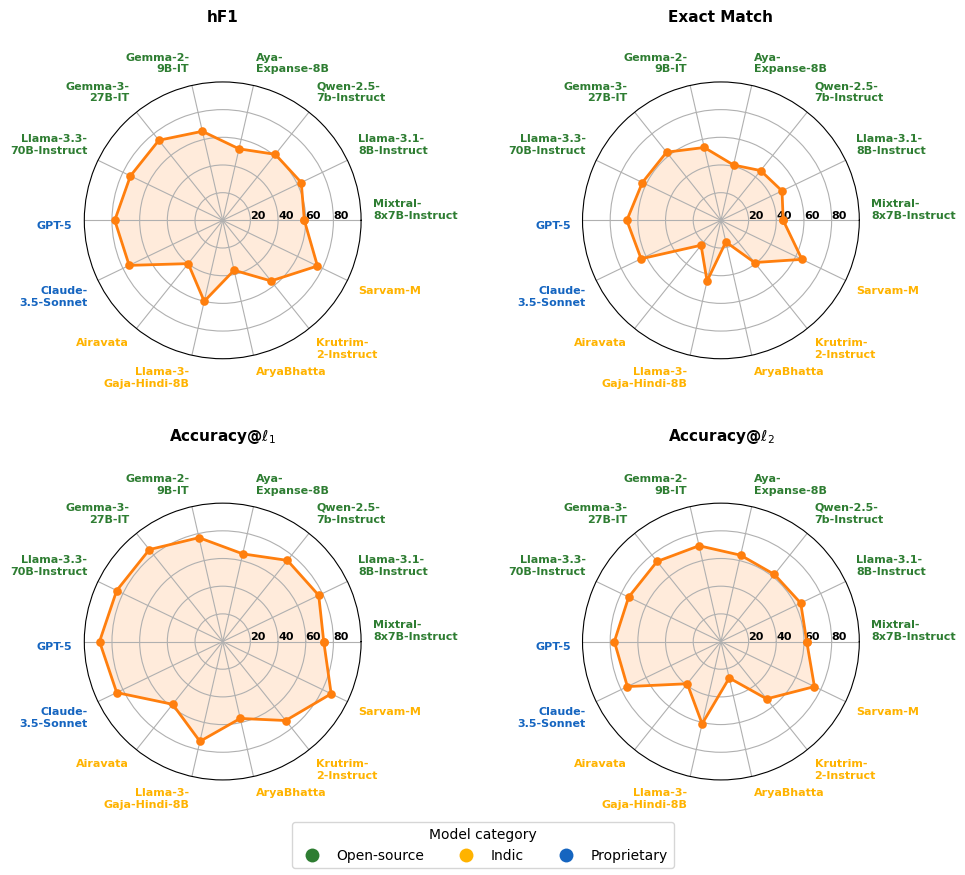

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.lines import Line2D

# ----------------------------
# Style
# ----------------------------
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10

# ----------------------------
# Category mapping (for label colors only)
# ----------------------------
category_of = {
    # Open-source
    "Llama-3.1-8B-Instruct": "Open-source",
    "Gemma-2-9B-IT": "Open-source",
    "Qwen-2.5-7b-Instruct": "Open-source",
    "Mixtral-8x7B-Instruct": "Open-source",
    "Aya-Expanse-8B": "Open-source",
    "Gemma-3-27B-IT": "Open-source",
    "Llama-3.3-70B-Instruct": "Open-source",
    # Indic
    "Llama-3-Gaja-Hindi-8B": "Indic",
    "AryaBhatta": "Indic",
    "Airavata": "Indic",
    "Krutrim-2-Instruct": "Indic",
    "Sarvam-M": "Indic",
    # Proprietary
    "GPT-5": "Proprietary",
    "Claude-3.5-Sonnet": "Proprietary",
}

# High-contrast label text colors (for readability on white)
category_color = {
    "Open-source": "#2E7D32",   # dark green
    "Indic":       "#FFB300", #"#E65100",   # deep orange
    "Proprietary": "#1565C0",   # dark blue
}

# ----------------------------
# Metric polygon colors (keep yours)
# ----------------------------
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # one color per metric
colors = ["#ff7f0e", "#ff7f0e", "#ff7f0e", "#ff7f0e"]  # one color per metric


fill_alphas = [0.15, 0.15, 0.15, 0.15]

# ----------------------------
# Helper to wrap long labels
# ----------------------------
def wrap_label(name, max_len=12):
    """
    Wrap long labels into two lines.
    Prefer breaking at hyphens; otherwise break near the middle.
    """
    if len(name) <= max_len:
        return name
    if "-" in name:
        parts = name.split("-")
        # split roughly in half
        mid = len(parts) // 2
        return "-".join(parts[:mid]) + "-" + "\n" + "-".join(parts[mid:])
    # fallback: hard wrap near middle
    mid = len(name) // 2
    return name[:mid] + "\n" + name[mid:]

labels_wrapped = [wrap_label(m, max_len=12) for m in models]

# ----------------------------
# Figure: 2x2 polar subplots
# ----------------------------
fig, axes = plt.subplots(2, 2, subplot_kw=dict(polar=True), figsize=(10, 9))
metrics = list(scores.keys())
metric_handles = []

for i, ax in enumerate(axes.flat):
    metric = metrics[i]
    N = len(models)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
    vals = list(scores[metric]) + scores[metric][:1]

    # Polygon per metric
    h, = ax.plot(
        angles, vals,
        linewidth=2,
        color=colors[i],
        marker="o", markersize=5, markeredgewidth=1.2,
        label=metric
    )
    ax.fill(angles, vals, alpha=fill_alphas[i], color=colors[i])
    
    metric_handles.append(h)

    # Model labels (wrapped)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels_wrapped, fontsize=8, fontweight="normal")
    ax.tick_params(axis='x', pad=-2)  # a bit more padding helps

    # Color each model label by category
    for label, m in zip(ax.get_xticklabels(), models):
        label.set_color(category_color[category_of[m]])
        label.set_fontweight("semibold")

    # Keep labels readable (no rotation; wrapping + padding handles crowding)
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        label.set_rotation(0)
        if angle < math.pi/2 or angle > 3*math.pi/2:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
        if angle < math.pi:
            label.set_verticalalignment('bottom')
        else:
            label.set_verticalalignment('top')

    # Radial ticks
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["20", "40", "60", "80"], fontsize=8, fontweight="semibold")  # no % sign
    ax.set_ylim(0, 1)

    # Title
    ax.set_title(metric, va='bottom', fontsize=11, fontweight="semibold", pad=20)

# Layout: leave extra room at bottom for two legends
plt.subplots_adjust(hspace=0.50, wspace=0.8, bottom=0.1)

# ----------------------------
# Two legends side-by-side at bottom
# ----------------------------
# Left: Metrics legend
# fig.legend(
#     handles=metric_handles,
#     loc='lower center',
#     bbox_to_anchor=(0.30, 0.02),  # left side
#     ncol=4,
#     fontsize=9,
#     title="Metrics",
# )

# Right: Category legend (explains label text colors)
cat_handles = [
    Line2D([0],[0], marker='o', color='none', markerfacecolor=col, markeredgecolor='none',
           label=cat, markersize=10)
    for cat, col in [("Open-source", category_color["Open-source"]),
                     ("Indic", category_color["Indic"]),
                     ("Proprietary", category_color["Proprietary"])]
]
fig.legend(
    handles=cat_handles,
    loc='lower center',
    # bbox_to_anchor=(0.80, 0.02),  # right side
    ncol=3,
    fontsize=10,
    title="Model category",
)

# Save (optional)
save_path = "../figures/radar_metrics_grid_spaced.png"
fig.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.2)
fig.savefig("../figures/JMIR_Fig/radar_metrics_grid_spaced.png", dpi=120, bbox_inches="tight", pad_inches=0.2)
print(f"Saved to: {save_path}")
plt.show()


In [ ]:
from PIL import Image

img = Image.open("../figures/JMIR_Fig/radar_metrics_grid_spaced.png")
print(img.size) 

(1184, 1076)


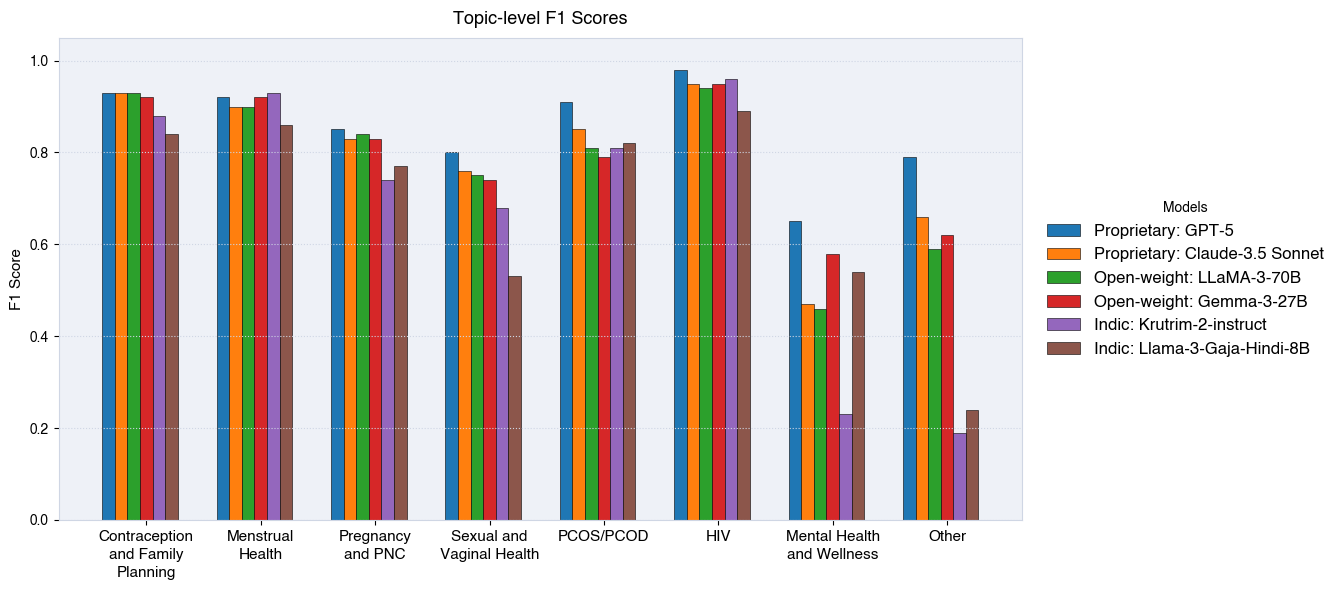

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# -------- Data --------
#gpt-4o
# Contraception and Family Planning = 0.94
# Menstrual Health = 0.92
# Pregnancy and PNC = 0.87
# Sexual and Vaginal Health = 0.79
# PCOS/PCOD = 0.85
# HIV = 0.97
# Mental Health and Wellness = 0.63
# Other = 0.75

# output/gpt-5.json
# ----------------------------------------
# Contraception and Family Planning = 0.93
# Menstrual Health = 0.92
# Pregnancy and PNC = 0.85
# Sexual and Vaginal Health = 0.8
# PCOS/PCOD = 0.91
# HIV = 0.98
# Mental Health and Wellness = 0.65
# Other = 0.79



# claude-3.5-sonnet
# ----------------------------------------
# Contraception and Family Planning = 0.93
# Menstrual Health = 0.9
# Pregnancy and PNC = 0.83
# Sexual and Vaginal Health = 0.76
# PCOS/PCOD = 0.85
# HIV = 0.95
# Mental Health and Wellness = 0.47
# Other = 0.66


# llama3.3-70b
# ----------------------------------------
# Contraception and Family Planning = 0.93
# Menstrual Health = 0.9
# Pregnancy and PNC = 0.84
# Sexual and Vaginal Health = 0.75
# PCOS/PCOD = 0.81
# HIV = 0.94
# Mental Health and Wellness = 0.46
# Other = 0.59

# gemma-3-27b
# ----------------------------------------
# Contraception and Family Planning = 0.92
# Menstrual Health = 0.92
# Pregnancy and PNC = 0.83
# Sexual and Vaginal Health = 0.74
# PCOS/PCOD = 0.79
# HIV = 0.95
# Mental Health and Wellness = 0.58
# Other = 0.62


# Llama-3-Gaja-Hindi-8B
# ----------------------------------------
# Contraception and Family Planning = 0.84
# Menstrual Health = 0.86
# Pregnancy and PNC = 0.77
# Sexual and Vaginal Health = 0.53
# PCOS/PCOD = 0.82
# HIV = 0.89
# Mental Health and Wellness = 0.54
# Other = 0.24


# Airavata
# ----------------------------------------
# Contraception and Family Planning = 0.71
# Menstrual Health = 0.74
# Pregnancy and PNC = 0.48
# Sexual and Vaginal Health = 0.46
# PCOS/PCOD = 0.87
# HIV = 0.84
# Mental Health and Wellness = 0.21
# Other = 0.0

# output/Krutrim.json
# ----------------------------------------
# Contraception and Family Planning = 0.88
# Menstrual Health = 0.93
# Pregnancy and PNC = 0.74
# Sexual and Vaginal Health = 0.68
# PCOS/PCOD = 0.81
# HIV = 0.96
# Mental Health and Wellness = 0.23
# Other = 0.19

# output/sarvam-m.json
# ----------------------------------------
# Contraception and Family Planning = 0.92
# Menstrual Health = 0.92
# Pregnancy and PNC = 0.84
# Sexual and Vaginal Health = 0.78
# PCOS/PCOD = 0.8
# HIV = 0.95
# Mental Health and Wellness = 0.62
# Other = 0.7


topics = [
    "Contraception and Family Planning", "Menstrual Health", "Pregnancy and PNC", "Sexual and Vaginal Health",
    "PCOS/PCOD", "HIV", "Mental Health and Wellness", "Other"
]

scores_dict = {
    # "GPT-4o":              [0.94, 0.92, 0.87, 0.79, 0.85, 0.97, 0.63, 0.75],
    "GPT-5":                 [0.93, 0.92, 0.85, 0.80, 0.91, 0.98, 0.65, 0.79],
    "Claude-3.5 Sonnet":     [0.93, 0.90, 0.83, 0.76, 0.85, 0.95, 0.47, 0.66],
    "LLaMA-3-70B":           [0.93, 0.90, 0.84, 0.75, 0.81, 0.94, 0.46, 0.59],
    "Gemma-3-27B":           [0.92, 0.92, 0.83, 0.74, 0.79, 0.95, 0.58, 0.62], 
    "Krutrim-2-instruct":    [0.88, 0.93, 0.74, 0.68, 0.81, 0.96, 0.23, 0.19],
    "Sarvam-M":              [0.92, 0.92, 0.84, 0.78, 0.80, 0.95, 0.62, 0.70],
    "Llama-3-Gaja-Hindi-8B": [0.84, 0.86, 0.77, 0.53, 0.82, 0.89, 0.54, 0.24],
    "Airavata":              [0.71, 0.74, 0.48, 0.46, 0.87, 0.84, 0.21, 0.00], 
}

# Keep models in this order
models = [
    "GPT-5", "Claude-3.5 Sonnet",     # Proprietary
    "LLaMA-3-70B", "Gemma-3-27B",      # Open-weight
    "Krutrim-2-instruct", "Llama-3-Gaja-Hindi-8B", "Airavata" # Indic
]

# Category for each model (same order as above)
categories = [
    "Proprietary", "Proprietary",
    "Open-weight", "Open-weight",
    "Indic", "Indic"
]

# -------- Style (HealthBench-like) --------
plt.rcParams["font.family"]  = "Helvetica"
plt.rcParams["font.size"]    = 10
plt.rcParams["font.stretch"] = "expanded"  # global default stretch a bit

FIG_BG, AX_BG, GRID_CLR = "white", "#eef1f7", "#cfd6e4"
tab10 = list(plt.cm.tab10.colors)

# --- Word-safe wrapper (no mid-word breaks) ---
def wrap_words(s, width=12, max_lines=3):
    parts = textwrap.wrap(
        s, width=width,
        break_long_words=False,
        break_on_hyphens=False
    )
    if len(parts) > max_lines:
        parts = parts[:max_lines-1] + [" ".join(parts[max_lines-1:])]
    return "\n".join(parts)

# Manual clean splits for longest labels
manual_wrap = {
    "Contraception and Family Planning": "Contraception\nand Family\nPlanning",
    "Sexual and Vaginal Health":         "Sexual and\nVaginal Health",
    "Mental Health and Wellness":        "Mental Health\nand Wellness"
}
wrapped_topics = [manual_wrap.get(t, wrap_words(t, width=12, max_lines=3)) for t in topics]

# -------- Plot --------
fig, ax = plt.subplots(figsize=(13.5, 6), facecolor=FIG_BG)
ax.set_facecolor(AX_BG)

x = np.arange(len(topics))
bar_width = 0.11  # slightly narrower so groups don't crowd labels
offsets = [i * bar_width for i in range(len(models))]

# Bars (no value labels on top)
handles = []
labels  = []
for i, (model, cat) in enumerate(zip(models, categories)):
    h = ax.bar(
        x + offsets[i],
        scores_dict[model],
        width=bar_width,
        label=f"{cat}: {model}",          # <- legend text prefixed by category
        color=tab10[i % len(tab10)],
        edgecolor="black",
        linewidth=0.4
    )
    handles.append(h[0])
    labels.append(f"{cat}: {model}")

# Axis formatting
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(wrapped_topics, rotation=0, ha="center", fontsize=11)

# Loosen typography for x labels: more line spacing + wider glyphs
for lbl in ax.get_xticklabels():
    lbl.set_linespacing(1.38)
    try:
        lbl.set_fontstretch("expanded")
    except Exception:
        pass

ax.set_ylabel("F1 Score", fontsize=11)
ax.set_ylim(0.0, 1.05)
ax.yaxis.grid(True, linestyle=":", linewidth=0.8, color=GRID_CLR)
for spine in ax.spines.values():
    spine.set_color(GRID_CLR)

ax.set_title(
    "Topic-level F1 Scores",
    fontsize=13, fontweight="normal", pad=10
)

# Legend on the right (shows “Proprietary: GPT-4o”, etc.)
plt.subplots_adjust(bottom=0.24, right=0.82)  # more bottom for 3-line labels
leg = ax.legend(
    handles=handles, labels=labels,
    title="Models",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    frameon=False, fancybox=False, fontsize=12
)

plt.tight_layout()

# Save (uncomment for paper-ready export)
fig.savefig("../figures/topic_level_F1_scores.png", dpi=600, bbox_inches="tight", pad_inches=0.2)
# fig.savefig("topic_level_F1_scores.pdf", bbox_inches="tight", pad_inches=0.5)

plt.show()

# Topic-level classification performance (F1) across SRH topics for six representative models on the SRHQA Dataset. 

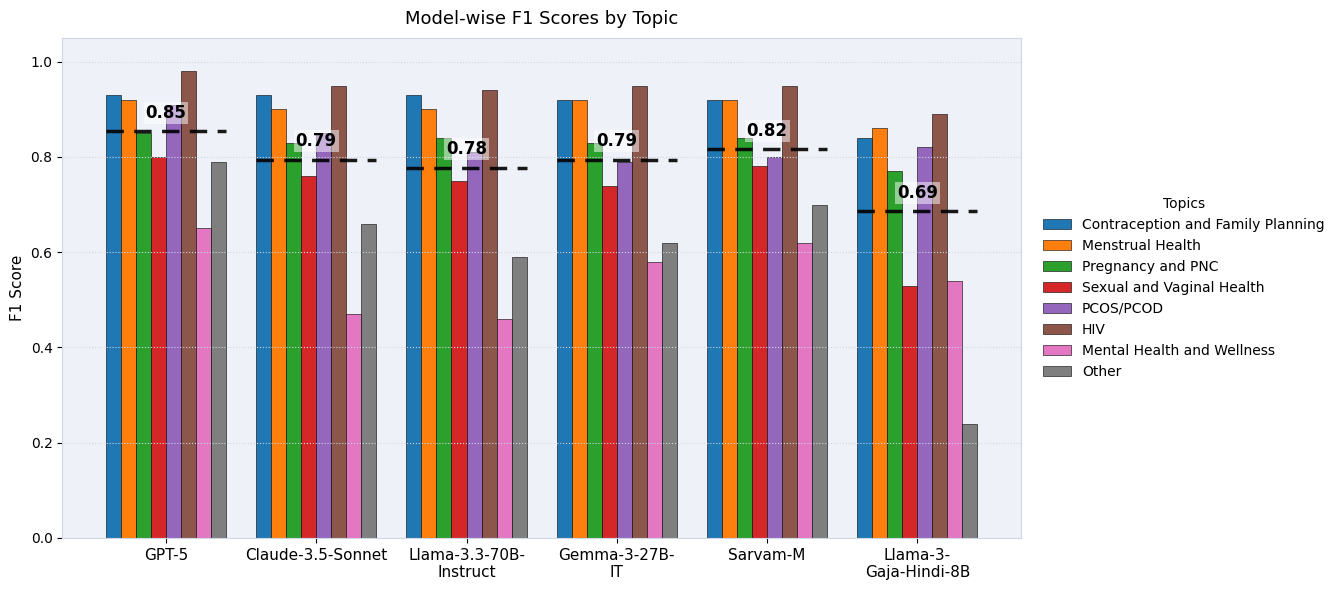

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# -----------------------------
# Data (same as your final)
# -----------------------------
topics = [
    "Contraception and Family Planning", "Menstrual Health", "Pregnancy and PNC",
    "Sexual and Vaginal Health", "PCOS/PCOD", "HIV", "Mental Health and Wellness", "Other"
]

scores_dict = {
    # "GPT-4o":              [0.94, 0.92, 0.87, 0.79, 0.85, 0.97, 0.63, 0.75],
    "GPT-5":                 [0.93, 0.92, 0.85, 0.80, 0.91, 0.98, 0.65, 0.79],
    "Claude-3.5-Sonnet":     [0.93, 0.90, 0.83, 0.76, 0.85, 0.95, 0.47, 0.66],
    "Llama-3.3-70B-Instruct":[0.93, 0.90, 0.84, 0.75, 0.81, 0.94, 0.46, 0.59],
    "Gemma-3-27B-IT":        [0.92, 0.92, 0.83, 0.74, 0.79, 0.95, 0.58, 0.62], 
    # "Krutrim-2-instruct":    [0.88, 0.93, 0.74, 0.68, 0.81, 0.96, 0.23, 0.19],
    "Llama-3-Gaja-Hindi-8B": [0.84, 0.86, 0.77, 0.53, 0.82, 0.89, 0.54, 0.24],
    "Sarvam-M":              [0.92, 0.92, 0.84, 0.78, 0.80, 0.95, 0.62, 0.70],
}
# Keep models in this order
models = [
    "GPT-5", "Claude-3.5-Sonnet",     # Proprietary
    "Llama-3.3-70B-Instruct", "Gemma-3-27B-IT",      # Open-weight
    "Sarvam-M", "Llama-3-Gaja-Hindi-8B" # Indic
]

# -----------------------------
# Style (HealthBench-like)
# -----------------------------
plt.rcParams["font.family"]  = "DejaVu Sans"   # or "DejaVu Sans"
plt.rcParams["font.size"]    = 10
plt.rcParams["font.stretch"] = "expanded"

FIG_BG, AX_BG, GRID_CLR = "white", "#eef1f7", "#cfd6e4"
tab10 = list(plt.cm.tab10.colors)  # distinct colors for 8 topics

# Optional: wrap the long model name to 2 lines
def wrap_model_name(s):
    if s == "Llama-3-Gaja-Hindi-8B":
        return "Llama-3-\nGaja-Hindi-8B"
    if s == "Krutrim-2-Instruct":
        return "Krutrim-2-\nInstruct"
    if s == "Llama-3.3-70B-Instruct":
        return "Llama-3.3-70B-\nInstruct"
    if s == "Gemma-3-27B-IT":
        return "Gemma-3-27B-\nIT"
    return s

wrapped_models = [wrap_model_name(m) for m in models]

# -----------------------------
# Build topic-wise arrays over models
# -----------------------------
topic_series = {
    topic: [scores_dict[m][j] for m in models]
    for j, topic in enumerate(topics)
}

# -----------------------------
# Plot (models on X, bars = topics)
# -----------------------------
fig, ax = plt.subplots(figsize=(13.5, 6), facecolor=FIG_BG)
ax.set_facecolor(AX_BG)

x = np.arange(len(models))
bar_width = 0.10  # small, since 8 bars per model

# Offsets for 8 topics around each model tick
offsets = [i * bar_width for i in range(len(topics))]
center_offset = bar_width * (len(topics) - 1) / 2.0

# Draw bars
handles, labels = [], []
for i, topic in enumerate(topics):
    vals = topic_series[topic]
    h = ax.bar(
        x - center_offset + offsets[i],
        vals,
        width=bar_width,
        color=tab10[i % len(tab10)],
        edgecolor="black",
        linewidth=0.4,
        label=topic
    )
    handles.append(h[0]); labels.append(topic)

# -----------------------------
# Dotted average line per MODEL
# -----------------------------
for k, m in enumerate(models):
    # mean across topics for this model
    avg = np.mean(scores_dict[m])

    # span the full width of the bar cluster for this model
    xmin = (x[k] - center_offset) - 0.05
    xmax = (x[k] + center_offset) + 0.05

    ax.hlines(
        y=avg,
        xmin=xmin, xmax=xmax,
        colors="black",
        linestyles=(0, (5, 3)),   # custom dash pattern
        linewidth=2.5,            # thick bold line
        alpha=0.9
    )
    # Bold label with white outline ("weight share" effect)
    ax.text(
        x[k], avg + 0.02, f"{avg:.2f}",
        ha="center", va="bottom",
        fontsize=12, fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", pad=1.5, alpha=0.5)  # small white background
    )

# -----------------------------
# Axes formatting
# -----------------------------
ax.set_xticks(x)
ax.set_xticklabels(wrapped_models, rotation=0, ha="center", fontsize=11)
for lbl in ax.get_xticklabels():
    try: lbl.set_fontstretch("expanded")
    except Exception: pass

ax.set_ylabel("F1 Score", fontsize=11)
ax.set_ylim(0.0, 1.05)
ax.yaxis.grid(True, linestyle=":", linewidth=0.8, color=GRID_CLR)
for spine in ax.spines.values():
    spine.set_color(GRID_CLR)

ax.set_title("Model-wise F1 Scores by Topic", fontsize=13, fontweight="normal", pad=10)

# Legend on the right: topics
plt.subplots_adjust(bottom=0.20, right=0.82)
leg = ax.legend(
    handles=handles, labels=labels,
    title="Topics",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    frameon=False, fancybox=False, fontsize=10
)

plt.tight_layout()

# Save if needed
fig.savefig("../figures/model_wise_F1_by_topic_with_avglines.png", dpi=600, bbox_inches="tight", pad_inches=0.2)
fig.savefig("../figures/JMIR_Fig/model_wise_F1_by_topic_with_avglines.png", dpi=80, bbox_inches="tight", pad_inches=0.2)
# fig.savefig("figures/model_wise_F1_by_topic_with_avglines.pdf", bbox_inches="tight", pad_inches=0.2)

plt.show()


In [ ]:
from PIL import Image

img = Image.open("../figures/JMIR_Fig/model_wise_F1_by_topic_with_avglines.png")
print(img.size) 

(1090, 489)


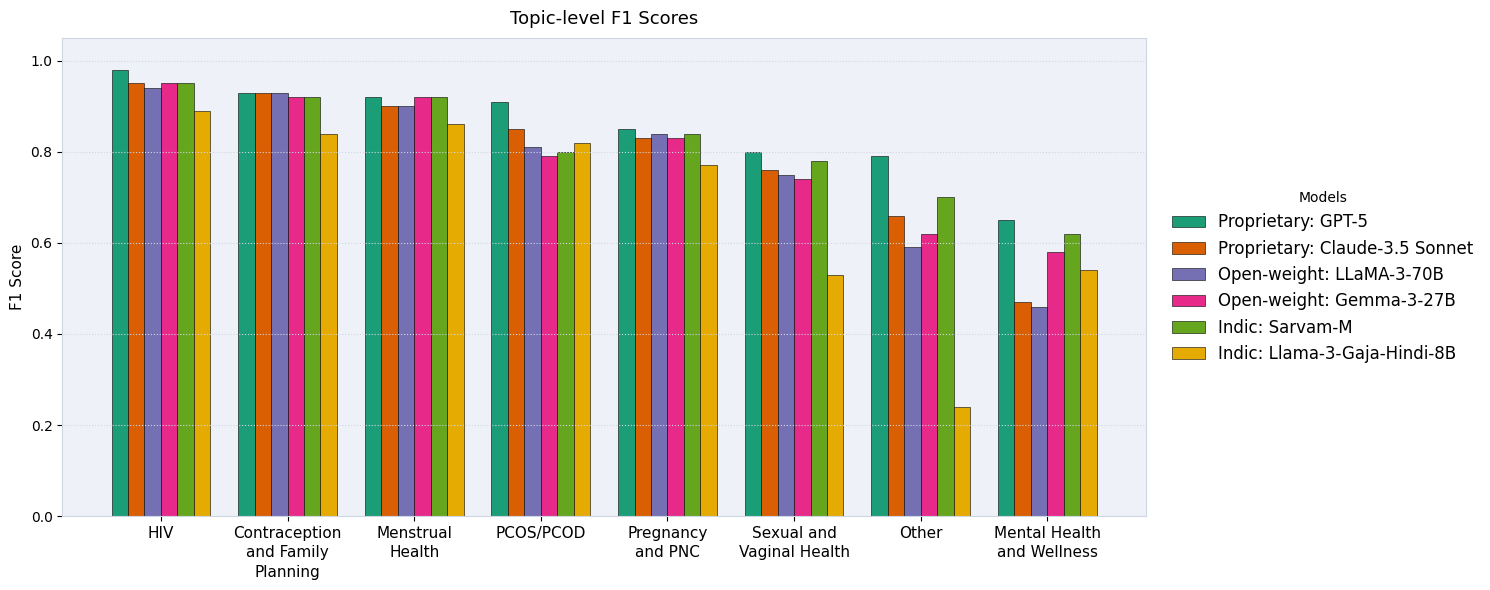

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# -------- Data --------
#gpt-4o
# Contraception and Family Planning = 0.94
# Menstrual Health = 0.92
# Pregnancy and PNC = 0.87
# Sexual and Vaginal Health = 0.79
# PCOS/PCOD = 0.85
# HIV = 0.97
# Mental Health and Wellness = 0.63
# Other = 0.75


# claude-3.5-sonnet
# ----------------------------------------
# Contraception and Family Planning = 0.93
# Menstrual Health = 0.9
# Pregnancy and PNC = 0.83
# Sexual and Vaginal Health = 0.76
# PCOS/PCOD = 0.85
# HIV = 0.95
# Mental Health and Wellness = 0.47
# Other = 0.66


# llama3.3-70b
# ----------------------------------------
# Contraception and Family Planning = 0.93
# Menstrual Health = 0.9
# Pregnancy and PNC = 0.84
# Sexual and Vaginal Health = 0.75
# PCOS/PCOD = 0.81
# HIV = 0.94
# Mental Health and Wellness = 0.46
# Other = 0.59

# gemma-3-27b
# ----------------------------------------
# Contraception and Family Planning = 0.92
# Menstrual Health = 0.92
# Pregnancy and PNC = 0.83
# Sexual and Vaginal Health = 0.74
# PCOS/PCOD = 0.79
# HIV = 0.95
# Mental Health and Wellness = 0.58
# Other = 0.62


# LLama3-Gaja-Hindi-8B
# ----------------------------------------
# Contraception and Family Planning = 0.84
# Menstrual Health = 0.86
# Pregnancy and PNC = 0.77
# Sexual and Vaginal Health = 0.53
# PCOS/PCOD = 0.82
# HIV = 0.89
# Mental Health and Wellness = 0.54
# Other = 0.24


# Airavata
# ----------------------------------------
# Contraception and Family Planning = 0.71
# Menstrual Health = 0.74
# Pregnancy and PNC = 0.48
# Sexual and Vaginal Health = 0.46
# PCOS/PCOD = 0.87
# HIV = 0.84
# Mental Health and Wellness = 0.21
# Other = 0.0


# output/Krutrim.json
# ----------------------------------------
# Contraception and Family Planning = 0.88
# Menstrual Health = 0.93
# Pregnancy and PNC = 0.74
# Sexual and Vaginal Health = 0.68
# PCOS/PCOD = 0.81
# HIV = 0.96
# Mental Health and Wellness = 0.23
# Other = 0.19


topics = [
    "Contraception and Family Planning", "Menstrual Health", "Pregnancy and PNC",
    "Sexual and Vaginal Health", "PCOS/PCOD", "HIV", "Mental Health and Wellness", "Other"
]

scores_dict = {
    # "GPT-4o":              [0.94, 0.92, 0.87, 0.79, 0.85, 0.97, 0.63, 0.75],
    "GPT-5":                 [0.93, 0.92, 0.85, 0.80, 0.91, 0.98, 0.65, 0.79],
    "Claude-3.5 Sonnet":     [0.93, 0.90, 0.83, 0.76, 0.85, 0.95, 0.47, 0.66],
    "LLaMA-3-70B":           [0.93, 0.90, 0.84, 0.75, 0.81, 0.94, 0.46, 0.59],
    "Gemma-3-27B":           [0.92, 0.92, 0.83, 0.74, 0.79, 0.95, 0.58, 0.62], 
    "Krutrim-2-instruct":    [0.88, 0.93, 0.74, 0.68, 0.81, 0.96, 0.23, 0.19],
    "Sarvam-M":              [0.92, 0.92, 0.84, 0.78, 0.80, 0.95, 0.62, 0.70],
    "Llama-3-Gaja-Hindi-8B": [0.84, 0.86, 0.77, 0.53, 0.82, 0.89, 0.54, 0.24],
}
# Keep models in this order
models = [
    "GPT-5", "Claude-3.5 Sonnet",     # Proprietary
    "LLaMA-3-70B", "Gemma-3-27B",      # Open-weight
    "Sarvam-M", "Llama-3-Gaja-Hindi-8B" # Indic
]

# Category for each model (same order as above)
categories = [
    "Proprietary", "Proprietary",
    "Open-weight", "Open-weight",
    "Indic", "Indic"
]





# -------- Style (HealthBench-like) --------
plt.rcParams["font.family"]  = "DejaVu Sans"
plt.rcParams["font.size"]    = 10
plt.rcParams["font.stretch"] = "expanded"  # global default stretch a bit

FIG_BG, AX_BG, GRID_CLR = "white", "#eef1f7", "#cfd6e4"

# --- Word-safe wrapper (no mid-word breaks) ---
def wrap_words(s, width=12, max_lines=3):
    parts = textwrap.wrap(
        s, width=width,
        break_long_words=False,
        break_on_hyphens=False
    )
    if len(parts) > max_lines:
        parts = parts[:max_lines-1] + [" ".join(parts[max_lines-1:])]
    return "\n".join(parts)

# Manual clean splits for longest labels
manual_wrap = {
    "Contraception and Family Planning": "Contraception\nand Family\nPlanning",
    "Sexual and Vaginal Health":         "Sexual and\nVaginal Health",
    "Mental Health and Wellness":        "Mental Health\nand Wellness"
}

# --- Reorder topics by descending average F1 across models ---
topic_means = {t: np.mean([scores_dict[m][j] for m in models]) 
               for j, t in enumerate(topics)}

# Sort topics by mean value (highest → lowest)
sorted_topics = sorted(topic_means, key=topic_means.get, reverse=True)

# Rebuild wrapped labels in this new order
wrapped_topics = [manual_wrap.get(t, wrap_words(t, width=12, max_lines=3)) 
                  for t in sorted_topics]

# Reorder the scores_dict for plotting
sorted_scores_dict = {
    m: [scores_dict[m][topics.index(t)] for t in sorted_topics]
    for m in models
}


# -------- Plot --------
fig, ax = plt.subplots(figsize=(15, 6), facecolor=FIG_BG)
ax.set_facecolor(AX_BG)

x = np.arange(len(sorted_topics))  # now sorted
bar_width = 0.13  # slightly narrower so groups don't crowd labels
offsets = [i * bar_width for i in range(len(models))]

# Bars (no value labels on top)
handles = []
labels  = []
# Use Dark2 instead of tab10
deep_palette = list(plt.cm.Dark2.colors)

for i, (model, cat) in enumerate(zip(models, categories)):
    h = ax.bar(
        x + offsets[i],
        sorted_scores_dict[model],   # <- sorted values
        width=bar_width,
        label=f"{cat}: {model}",
        color=deep_palette[i % len(deep_palette)],
        edgecolor="black",
        linewidth=0.4
    )
    handles.append(h[0])
    labels.append(f"{cat}: {model}")


# Axis formatting
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(wrapped_topics, rotation=0, ha="center", fontsize=11)

# Loosen typography for x labels: more line spacing + wider glyphs
for lbl in ax.get_xticklabels():
    lbl.set_linespacing(1.38)
    try:
        lbl.set_fontstretch("expanded")
    except Exception:
        pass

ax.set_ylabel("F1 Score", fontsize=11)
ax.set_ylim(0.0, 1.05)
ax.yaxis.grid(True, linestyle=":", linewidth=0.8, color=GRID_CLR)
for spine in ax.spines.values():
    spine.set_color(GRID_CLR)

ax.set_title(
    "Topic-level F1 Scores",
    fontsize=13, fontweight="normal", pad=10
)

# Legend on the right (shows “Proprietary: GPT-4o”, etc.)
plt.subplots_adjust(bottom=0.24, right=0.82)  # more bottom for 3-line labels
leg = ax.legend(
    handles=handles, labels=labels,
    title="Models",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    frameon=False, fancybox=False, fontsize=12
)

plt.tight_layout()

# Save (uncomment for paper-ready export)
fig.savefig("../figures/topic_level_F1_scores.png", dpi=600, bbox_inches="tight", pad_inches=0.2)
# fig.savefig("topic_level_F1_scores.pdf", bbox_inches="tight", pad_inches=0.5)

plt.show()

# Topic-level classification performance (F1) across SRH topics for six representative models on the SRHQA Dataset. 